In [2]:
cd 

C:\Users\Seb


In [3]:
cd Google Drive (shg512@york.ac.uk)\Code\python\Research\Trap calibration

C:\Users\Seb\Google Drive (shg512@york.ac.uk)\Code\python\Research\Trap calibration


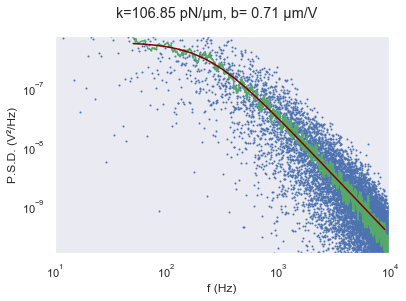

In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from os import getcwd, listdir, makedirs, path
from lmfit import Minimizer, Parameters
from numpy.fft import rfft, rfftfreq
from pandas import read_csv
from scipy.signal import periodogram
from scipy.stats import binned_statistic
from brownian import k_brown
from functions import anti_aliased_lorentzian, lorentzian
from settings import D, Fs, axl_correction, gamma, lat_correction

sns.set(color_codes=True)
sns.set_style("dark")
use_moving_average = True
anti_aliasing = False

def moving_average(data, window=30):
    extended_data = np.hstack([[data[0]] * (window - 1), data])
    weightings = np.repeat(1.0, window) / window
    return np.convolve(extended_data, weightings)[window-1:-(window-1)]

def calibrate(x, Fs, filename, plot_dir, cutoffs=None, antialiasing=None,
              axis='z'):
    plt.clf()
    plt.xscale('log')
    plt.yscale('log')

    f, p = periodogram(x, fs=Fs, return_onesided=True, scaling='density')
    plt.scatter(f, p, s=1)

    p, f = moving_average(p), moving_average(f)
    plt.plot(f, p, c='g')
    
    if not cutoffs: 
        if axis=='z':
            cutoffs = [50, 9000]  # z stiffness lower so cutoff needs to be lower
        else:
            cutoffs = [150, 9000]
        cutoff_condition = (f > cutoffs[0]) & (f < cutoffs[1])
        p = p[cutoff_condition]
        f = f[cutoff_condition]

    # Set initial parameters for fitting
    fc = 1000 if axis != "z" else 200
    Dv = 1e4 if axis != "z" else 500
   
    params = Parameters()
    params.add('Dv', value=Dv)
    params.add('fc', value=fc, min=-0, max=Fs/2)
    if anti_aliasing:
        params.add('fNyq', value=Fs/2)
        minner = Minimizer(anti_aliased_lorentzian, params, fcn_args=(f, p))
    else:
        minner = Minimizer(lorentzian, params, fcn_args=(f, p))
    result = minner.minimize()
    p_fit = p + result.residual

    plt.plot(f, p_fit, c='maroon')

    Dv, fc = result.params['Dv'].value, result.params['fc'].value
    Dv_err, fc_err = result.params['Dv'].stderr, result.params['fc'].stderr
    b = np.sqrt(D/Dv)  # in m/V
    # Taking derivative to get error (df^2 = (df/dx dx)^2 + ...)
    if Dv_err:
        bErr = np.sqrt(D / (4 * Dv**3)) * Dv_err
    else:
        bErr = 0
    # k = 2πγfc
    k = 2*np.pi*gamma*fc*1e6  # in pN/μm
    if fc_err:
        kErr = 2*np.pi*gamma*fc_err*1e6  # in pN/μm
    else:
        kErr = 0

    b, bErr = b * 1e6, bErr * 1e6  # in μm/V
    h_correction = axl_correction if axis == 'z'else lat_correction
    k, kErr = k/h_correction, kErr/h_correction

    plt.xlabel('f (Hz)')
    plt.ylabel('P.S.D. (V²/Hz)')
    plt.xlim(left=10, right=1.1*cutoffs[1])
    plt.ylim(bottom=0.9*min(p), top=1.1*max(p))
    plt.suptitle(f'k={k:4.2f} pN/μm, b= {b:4.2f} μm/V')
    save_file = path.join(getcwd(), 'plots')
    makedirs(save_file, exist_ok=True)
    # switch back to path.basename etc later
    save_file = path.join(plot_dir, path.splitext(filename)[0] + f'_{axis}')
    plt.savefig(save_file, bbox_inches='tight')
    # Plot and save result to file
    # plt.loglog(f, lorentzian(f, *popt))

    return k, kErr, b, bErr


def giveResult(data):
    string = str(np.average(data))[0:5] + ' +/- ' + \
             str(np.std(data)/np.sqrt(len(data)))[0:5]
    print(string)


class ResultContainer():
    def __init__(self):
        self.k = []
        self.k_err = []
        self.b = []
        self.b_err = []
        self.K = []
        self.K_err = []


def save_calibration_file(x, y, z):
    from settings import r, h, Fs
    global anti_aliasing
    data = {
        'k': {
            'x': np.average(x.k),
            'y': np.average(y.k),
            'z': np.average(z.k),
            'x_error': np.std(x.k),
            'y_error': np.std(y.k),
            'z_error': np.std(z.k),
            #'x_error_fit': np.average(x.k_err[x.k_err != 0]),
            #'y_error_fit': np.average(y.k_err[y.k_err != 0]),
            #'z_error_fit': np.average(z.k_err[z.k_err != 0]),
            },
        'b': {
            'x': np.average(x.b),
            'y': np.average(y.b),
            'z': np.average(z.b),
            'x_error': np.std(x.b),
            'y_error': np.std(y.b),
            'z_error': np.std(z.b),
            #'x_error_fit': np.average(x.b_err[x.b_err != 0]),
            #'y_error_fit': np.average(y.b_err[y.b_err != 0]),
            #'z_error_fit': np.average(z.b_err[z.b_err != 0])
            },
        'K': {
            'x': np.average(x.K),
            'y': np.average(y.K),
            'z': np.average(z.K),
            'y_error': np.std(y.K),
            'z_error': np.std(z.K)
            },
        'settings': {
            'anti-aliasing': anti_aliasing,
            'bead radius': r,
            'bead height': h,
            'Fs': Fs
            }
    }

    with open('calibration.json', 'w') as f:
        json.dump(data, f, indent=4)

data_dir = path.join(getcwd(), 'data')
plot_dir = path.join(getcwd(), 'plots', 'calibrations')
makedirs(plot_dir, exist_ok=True)

files = [f for f in listdir(data_dir) if 'spectrum' in f]

x = ResultContainer()
y = ResultContainer()
z = ResultContainer()
results = {'x': x, 'y': y, 'z': z}

for filename in files:
    data_file = path.join(data_dir, filename)
    data = read_csv(data_file, delimiter='\t',
                    usecols=(1, 2, 3), skiprows=1, header=None)
    data = data.values
    
    if use_moving_average== True:
        for i in range(3):
            data[:,i]=moving_average(data[:,i],5)

    signals = {'x': data[:, 0]/data[:, 2],
               'y': data[:, 1]/data[:, 2],
               'z': data[:, 2]}
    

    for axis, signal in signals.items():
        calibration = calibrate(signal, Fs, filename, plot_dir, axis=axis)
        results[axis].k.append(calibration[0])
        results[axis].k_err.append(calibration[1])
        results[axis].b.append(calibration[2])
        results[axis].b_err.append(calibration[3])
        results[axis].K.append(
            k_brown(signal, calibration[2], axis, filename))

save_calibration_file(x, y, z)


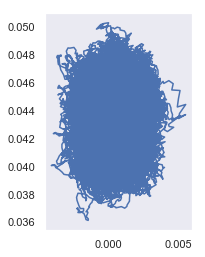

In [31]:
fig, ax = plt.subplots()
ax.plot(signals['x'],signals['y'])
ax.set_aspect('equal')

In [32]:
np.std(signals['y'])

0.0019521548706731306

In [33]:
    x = signals['y']*results['y'].b[-1]*1e3  # bead position [nm]
    x = x - np.mean(x)
    k_brown = 4.114 / np.std(x)**2
    k_brown = k_brown * 1e3  # convert to pN/um

In [34]:
k_brown

39.23626089122096

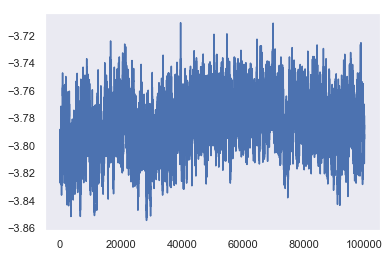

In [22]:
plt.plot(signal)